# Ch2 : 1D vector addition

> Parallelization of 1D vector addition

In [ ]:
#| default_exp ch2

<div style="display: flex; justify-content: space-between; align-items: center;">
  <span>📅 09/12/2025</span>
  <p align="right">
    <a href="https://colab.research.google.com/github/tripathysagar/PMPP/blob/main/nbs/02_ch2.ipynb" target="_blank">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
   </p>
</div>

In [ ]:
#|hide
%%capture
import sys
##
#If running in colab please switch run time to use GPU for leveraging CUDA.
##

def is_colab():
    return 'google.colab' in sys.modules


# Check if running in Google Colab
if is_colab():
  !git clone https://github.com/tripathysagar/PMPP.git
  %cd PMPP
  !pip install -e .


from PMPP.NumbaSimSetup import *

Setup simulation.

In [ ]:
if  is_colab():
  assert not is_sim()
else:
  set_sim()
  assert is_sim()


Allocate the memory on the CPU.

In [ ]:
import numpy as np
from numba import cuda

N = 10_000
a, b = np.random.randn(N), np.random.randn(N)
a.shape, b.shape

((10000,), (10000,))

### Sequential


In [ ]:
def add():
    c = np.zeros_like(a)
    for i in range(N):
        c[i] = a[i] + b[i]
    return c

c1 = add()

In [ ]:
%%timeit
add()

9.69 ms ± 3.19 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


{{< video https://www.youtube.com/watch?v=3yxhwooZKw8 >}}

### Parallel



### 1. Memory Allocation (Host ↔ Device)

For making the sequential loop parallel we have to leverage CUDA's multithread system. The CPU machine is called host while the GPU machine  is known as device. The GPU has its own separate memory (device global memory). To do work on the GPU

- **Allocate** memory on the device (`cudaMalloc`)
- **Copy** data from host (CPU) to device (GPU) (`cudaMemcpy`)
- Run your kernel
- **Copy** results back from device to host
- **Free** the device memory (`cudaFree`)

| CUDA C | Numba CUDA |
|--------|------------|
| `cudaMalloc` | `cuda.device_array()` |
| `cudaMemcpy` (host→device) | `cuda.to_device()` |
| `cudaMemcpy` (device→host) | `d_array.copy_to_host()` |
| `cudaFree` | Automatic (garbage collected) |


Think of it like packing a suitcase: you pack your data, send it to the GPU, do work there, then bring the results back.


### 2. Thread Allocation

When a kernel launches, the CUDA runtime creates a **grid of threads** organized in two levels:

- **Grid** = array of **blocks**
- Each **block** = up to 1024 **threads** (commonly 128-512 for efficiency)
- Each thread knows "who it is" via built-in variables (`threadIdx.x, blockIdx.x, blockDim.x`)
- Formula for each thread its unique global index calculation becomes : `i = blockIdx.x * blockDim.x + threadIdx.x`  

Each thread can identify itself using three built-in variables:

| Variable | Purpose |
|----------|---------|
| `threadIdx.x` | Thread's index *within* its block (0, 1, 2, ...) |
| `blockIdx.x` | The block's index *within* the grid |
| `blockDim.x` | Total number of threads per block |


Each thread executes the same code but works on different data (this is called SPMD — Single Program, Multiple Data). Continuing the suitcase metaphor each thread uses its unique index to work on one element of the data.

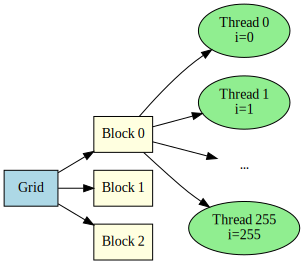

In [ ]:
#|echo: false
from graphviz import Digraph

g = Digraph('Thread Organization', format='png')
g.attr(rankdir='LR')  # Left to Right (horizontal)

# Grid
g.node('grid', 'Grid', shape='box', style='filled', fillcolor='lightblue')

# Blocks
g.node('b0', 'Block 0', shape='box', style='filled', fillcolor='lightyellow')
g.node('b1', 'Block 1', shape='box', style='filled', fillcolor='lightyellow')
g.node('b2', 'Block 2', shape='box', style='filled', fillcolor='lightyellow')

# Connect grid to blocks
g.edge('grid', 'b0')
g.edge('grid', 'b1')
g.edge('grid', 'b2')

# Threads for Block 0 (just showing a few)
g.node('t0', 'Thread 0\ni=0', shape='ellipse', style='filled', fillcolor='lightgreen')
g.node('t1', 'Thread 1\ni=1', shape='ellipse', style='filled', fillcolor='lightgreen')
g.node('t2', '...', shape='plaintext')
g.node('t255', 'Thread 255\ni=255', shape='ellipse', style='filled', fillcolor='lightgreen')

g.edge('b0', 't0')
g.edge('b0', 't1')
g.edge('b0', 't2')
g.edge('b0', 't255')

g


{{< video https://www.youtube.com/watch?v=722WnN2DoYI >}}

In [ ]:
NO_THREADS = 256
NO_BLOCKS = N/256
NO_THREADS, NO_BLOCKS

(256, 39.0625)

The 39.0625 is a floating point number. But it not physically possible we have to allocate block we have to use an int. By rounding down  39 * 256 = 9,984 thread but N = 10,000. We have to use ceil operation for that in the 40th block only 16 threads will be used and the rest will be idle during during computation. CUDA kernels need a bounds check, as 240 idle threads will still run the kernel code, but they'd be accessing memory out of bounds (indices 10,000 to 10,239). One has to be mindful for these idle blocks.

In [ ]:
import math
NO_BLOCKS = math.ceil(NO_BLOCKS)
NO_BLOCKS

40


### 3. Function qualifiers (how they map to Numba)


| CUDA C | Numba | Meaning |
|--------|-------|---------|
| `__global__` | `@cuda.jit` | Kernel - called from host, runs on device, launches grid |
| `__device__` | `@cuda.jit(device=True)` | Device function - called from kernel/device only |
| `__host__` | Regular Python function | Runs on CPU |



In [ ]:
@cuda.jit # compile the code to be run on GPU
def add_kernel(a, b, c):
    #idx = cuda.grid(1)
    idx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

    if idx < N and idx >= 0: # Boundary check
        c[idx] = a[idx] + b[idx]

In [ ]:
#c = np.zeros_like(a)
#assert c.shape == a.shape

#add_kernel[40, 256](a, b, c)
device(a), device(b)

If you are running using cuda sim. The function will run without any error. But there is subtle issue. We have to move data from cpu to gpu i.e. host to device before running the code other wise we will see following error:
```text
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 40 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
1.06 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:937: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
```

In [ ]:
# moving data to GPU
d_a = cuda.to_device(a)
d_b = cuda.to_device(b)
device(d_a), device(d_b)

('cuda', 'cuda')

In [ ]:
# allocating new array for holding computation
d_c = cuda.device_array(N, dtype=a.dtype)
device(d_c)

'cuda'

In [ ]:
%%timeit
add_kernel[40, 256](d_a, d_b, d_c)

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:697: NumbaPerformanceWarning: Grid size 40 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


45.2 µs ± 8.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


{{< video https://www.youtube.com/watch?v=kpQeVHs2Fec >}}

In [ ]:
test_close(d_c.copy_to_host(), c1)

True

## Conclusion

1. Note: If you are running in the CPU the code will not be faster due to simulation.
1. We have been able the converted the sequential loop to a parallel one to leverage GPU multithreads.